<a href="https://colab.research.google.com/github/mayorova-ma/majorova_project_backup/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22final_project_Majorova_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Люди смотрят сериалы по-разному: некоторые смотрят только самые лучшие, как хорошее кино-по серии в день, другие же выбирают binge-watching, и смотрят серии большими порциями, параллельно занимаясь дргуими делами. Не всегда понятно, почему тот или иной сериал понравился широкой публике, и потому сложно предугадать, сколько же еще сезонов сериал будет длиться. Для зрителей это может быть важно, чтобы или не начать смотреть что-то, что не стоит их внимания, или дождаться конца сериала, чтобы потом не ждать новых сезонов. Для создателей сериалов вопрос продления сериала на новый сезон всегда связан с прибылью компании-попытка предугадать отношение публики к сериалу на самом деле попытка предугадать прибыль от проекта.
Я решила рассмотреть изменения продолжительности сериалов с течением времени, связь рейтингов с продлением сериалов на новый сезон.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import plotly
import statsmodels.api as sm
from scipy import stats
import networkx as nx
sns.set()

In [ ]:
#ratings = pd.read_csv('/content/drive/MyDrive/title.ratings.tsv.gz', compression='gzip', header=0, sep='\t', na_values='\\N')
#episode = pd.read_csv('/content/drive/MyDrive/title.episode.tsv.gz', compression='gzip', header=0, sep='\t', na_values='\\N')

In [ ]:
#basics = pd.read_csv('/content/drive/MyDrive/title.basics (1).tsv.gz', compression='gzip', header=0, sep='\t', na_values='\\N')

Датасеты title.ratings.tsv.gz, title.episode.tsv.gz, title.basics.tsv.gz были взяты с https://datasets.imdbws.com/, их описание на сайте https://developer.imdb.com/non-commercial-datasets/#titlecrewtsvg. Файлы с датасетами большого объема, при загрузке иногда возникают ошибки, поэтому с ними были проведены операции в закомментированном коде, а затем были созданы новые датасеты, где отобраны именно сериалы, дальнейшая работа будет происходить с ними. Новые датасеты приложены.


In [ ]:
#basics['titleType'].unique()

В колонке titleType нас интересует все, что содержит в себе Series, поэтому посмотрим, что вообще есть в колонке и выберем нужное. В датасетах есть колонка tconst (string) - alphanumeric unique identifier of the title поэтому соединим нужные данные, а затем соединим сначала сами сериалы с их оценками, затем эпизоды с их оценками, а затем объединим эти данные (у эпизодов как объединяющий фактор берем "parentTconst", так как в датасете title.episode 'tconst' это идентификатор именно каждого отдельного эпизода).

In [ ]:
#tv_series = basics[(basics['titleType']=='tvSeries')|(basics['titleType']=='tvMiniSeries')]
#basics_episodes = basics[basics['titleType']=='tvEpisode']
#tv_series_ratings = pd.merge(tv_series, ratings, on='tconst')
#episode_ratings = pd.merge(episode, ratings, on='tconst')
#tv_series_episode_ratings = pd.merge(tv_series_ratings, episode_ratings, left_on='tconst', right_on='parentTconst')

Теперь прочитаем созданные файлы и будем далее работать с ними.

In [ ]:
tv_series = pd.read_csv('/content/tv_series.tsv.gz', compression='gzip', header=0, sep='\t', na_values='\\N')
tv_series_episode_ratings = pd.read_csv('/content/tv_series_episode_ratings.tsv.gz', compression='gzip', header=0, sep='\t', na_values='\\N')

Следующее что необходимо сделать-это обработать данные, чтобы избавиться от пропусков. Для этого нужно понять где есть пропуски.

In [ ]:
print(tv_series.isnull().any())

tconst            False
titleType         False
primaryTitle      False
originalTitle     False
isAdult           False
startYear          True
endYear            True
runtimeMinutes     True
genres             True
dtype: bool


In [ ]:
print(tv_series_episode_ratings.isnull().any())

tconst_x           False
titleType          False
primaryTitle       False
originalTitle      False
isAdult            False
startYear           True
endYear             True
runtimeMinutes      True
genres              True
averageRating_x    False
numVotes_x         False
tconst_y           False
parentTconst       False
seasonNumber        True
episodeNumber       True
averageRating_y    False
numVotes_y         False
dtype: bool


Для дальнейшего анализа важными являются столбцы с годом начала производства сериалов, номером эпизода и сезона. Поэтому удалим строки, в которых эти значения отсутствуют.

In [ ]:
tv_series_episode_ratings=tv_series_episode_ratings.dropna(subset=['startYear', 'seasonNumber', 'episodeNumber','runtimeMinutes'])
print(tv_series_episode_ratings.isnull().any())

tconst_x           False
titleType          False
primaryTitle       False
originalTitle      False
isAdult            False
startYear          False
endYear             True
runtimeMinutes     False
genres              True
averageRating_x    False
numVotes_x         False
tconst_y           False
parentTconst       False
seasonNumber       False
episodeNumber      False
averageRating_y    False
numVotes_y         False
dtype: bool


In [ ]:
tv_series=tv_series.dropna(subset=['startYear'])
print(tv_series.isnull().any())

tconst            False
titleType         False
primaryTitle      False
originalTitle     False
isAdult           False
startYear         False
endYear            True
runtimeMinutes     True
genres             True
dtype: bool


Я решила рассмотреть сериалы, созданные с 1980 года и по 2024 (стоит отметить, что чем меньше времени прошло с года создания первого сезона, тем больше вероятность того, что сериал еще не закончен. Кроме того, отметим, что сериалы должны были получить хотя бы 2000 голосов, чтобы убрать какие-то случайно упомянутые вещи.

In [ ]:
tv_series_startYear = tv_series[tv_series['startYear'] != '\\N']
tv_series_startYear['startYear'] = pd.to_datetime(tv_series_startYear['startYear'], format='%Y')
tvseries_startYear= tv_series_startYear[(tv_series_startYear['startYear'] <= '2024') & (tv_series_startYear['startYear'] >= '1980')]
tvseries_startYear

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1652,tt0062614,tvSeries,Zeg 'ns Aaa,Zeg 'ns Aaa,0.0,1981-01-01,2010.0,23.0,Comedy
2429,tt0072584,tvSeries,Wheel of Fortune,Wheel of Fortune,0.0,1983-01-01,NaN,30.0,"Family,Game-Show"
2613,tt0075509,tvMiniSeries,France/tour/détour/deux/enfants,France/tour/détour/deux/enfants,0.0,1980-01-01,1980.0,26.0,Documentary
2655,tt0075554,tvSeries,Otkrytaya kniga,Otkrytaya kniga,0.0,1980-01-01,NaN,596.0,"Biography,Drama"
2724,tt0076980,tvSeries,Auf Achse,Auf Achse,0.0,1980-01-01,1996.0,48.0,"Adventure,Crime"
...,...,...,...,...,...,...,...,...,...
319196,tt9916206,tvSeries,Nojor,Nojor,0.0,2019-01-01,NaN,20.0,Fantasy
319198,tt9916216,tvSeries,Kalyanam Mudhal Kadhal Varai,Kalyanam Mudhal Kadhal Varai,0.0,2014-01-01,2017.0,22.0,Romance
319199,tt9916218,tvSeries,Lost in Food,Lost in Food,0.0,2016-01-01,2017.0,NaN,Talk-Show
319200,tt9916380,tvSeries,Meie aasta Aafrikas,Meie aasta Aafrikas,0.0,2019-01-01,NaN,43.0,"Adventure,Comedy,Family"


Для начала рассмотрим, как менялось количество созданных сериалов с течением времени.

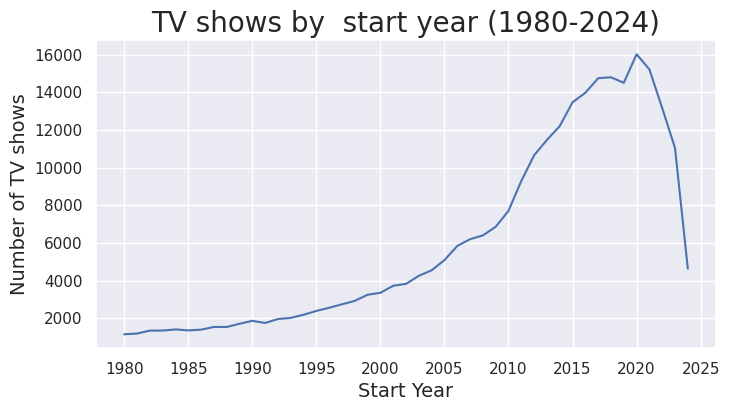

In [ ]:
fig1 = plt.figure(figsize=(8,4))
series_counted = tvseries_startYear.groupby('startYear')[['tconst']].count().reset_index()
series_counted =series_counted [(series_counted['startYear'] >= '1980') & (series_counted['startYear'] <= '2024')]
series_counted.rename(columns={'tconst':'Shows_counted'}, inplace=True)
ax = sns.lineplot(x='startYear',y='Shows_counted',data=series_counted)
ax.set_xlabel("Start Year",fontsize=14)
ax.set_ylabel("Number of TV shows",fontsize=14)
plt.title(label='TV shows by  start year (1980-2024)', fontsize=20)
fig1.savefig('fig1.png', dpi=fig1.dpi)

Видно, что около 2010 года прирост количества новых сериалов начинает ускоряться, индустрия развивается, количество достигает своего пика в 2020 году, и затем резко падает. Вероятнее всего это связано с тем, что сериалы выходят через год и более после съемок, и в связи с ковидными ограничениями количество снятых и выпущенных сериалов сильно уменьшилось.

In [ ]:
tv_series_episode_ratings = tv_series_episode_ratings[tv_series_episode_ratings['startYear'] != '\\N']
tv_series_episode_ratings['startYear'] = pd.to_datetime(tv_series_episode_ratings['startYear'], format='%Y')
tv_series_episode_ratings_years= tv_series_episode_ratings[(tv_series_episode_ratings['startYear'] <= '2024') & (tv_series_episode_ratings['startYear'] >= '1980')]
tv_series_episode_ratings_years

,tconst_x,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating_x,numVotes_x,tconst_y,parentTconst,seasonNumber,episodeNumber,averageRating_y,numVotes_y
37705,tt0062614,tvSeries,Zeg 'ns Aaa,Zeg 'ns Aaa,0.0,1981-01-01,2010.0,23.0,Comedy,6.7,366,tt1075736,tt0062614,8.0,13.0,6.0,6
52012,tt0072584,tvSeries,Wheel of Fortune,Wheel of Fortune,0.0,1983-01-01,NaN,30.0,"Family,Game-Show",6.7,3587,tt1614316,tt0072584,1.0,1.0,8.2,19
52013,tt0072584,tvSeries,Wheel of Fortune,Wheel of Fortune,0.0,1983-01-01,NaN,30.0,"Family,Game-Show",6.7,3587,tt29536371,tt0072584,41.0,26.0,5.4,5
52014,tt0072584,tvSeries,Wheel of Fortune,Wheel of Fortune,0.0,1983-01-01,NaN,30.0,"Family,Game-Show",6.7,3587,tt29845958,tt0072584,41.0,42.0,5.8,5
55696,tt0075509,tvMiniSeries,France/tour/détour/deux/enfants,France/tour/détour/deux/enfants,0.0,1980-01-01,1980.0,26.0,Documentary,7.3,132,tt3817684,tt0075509,1.0,1.0,7.0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720519,tt9916380,tvSeries,Meie aasta Aafrikas,Meie aasta Aafrikas,0.0,2019-01-01,NaN,43.0,"Adventure,Comedy,Family",8.2,119,tt10197828,tt9916380,1.0,6.0,10.0,15
720520,tt9916380,tvSeries,Meie aasta Aafrikas,Meie aasta Aafrikas,0.0,2019-01-01,NaN,43.0,"Adventure,Comedy,Family",8.2,119,tt10197842,tt9916380,1.0,8.0,10.0,15
720521,tt9916380,tvSeries,Meie aasta Aafrikas,Meie aasta Aafrikas,0.0,2019-01-01,NaN,43.0,"Adventure,Comedy,Family",8.2,119,tt10197854,tt9916380,1.0,9.0,9.9,14
720522,tt9916380,tvSeries,Meie aasta Aafrikas,Meie aasta Aafrikas,0.0,2019-01-01,NaN,43.0,"Adventure,Comedy,Family",8.2,119,tt10197874,tt9916380,1.0,10.0,10.0,15


Обработаем данные о рейтингах от выбросов. Для этого найдем 5ый и 95 перцентиль, и заменим значения, оказывшиеся нише и выше соответственно на найденные значения.

In [ ]:
percentile_5_x = tv_series_episode_ratings['averageRating_x'].quantile(0.05)
percentile_95_x = tv_series_episode_ratings['averageRating_x'].quantile(0.95)
tv_series_episode_ratings.loc[tv_series_episode_ratings['averageRating_x'] < percentile_5_x, 'averageRating_x'] = percentile_5_x
tv_series_episode_ratings.loc[tv_series_episode_ratings['averageRating_x'] > percentile_95_x, 'averageRating_x'] = percentile_95_x
percentile_5_y = tv_series_episode_ratings['averageRating_y'].quantile(0.05)
percentile_95_y = tv_series_episode_ratings['averageRating_y'].quantile(0.95)
tv_series_episode_ratings.loc[tv_series_episode_ratings['averageRating_y'] < percentile_5_y, 'averageRating_y'] = percentile_5_y
tv_series_episode_ratings.loc[tv_series_episode_ratings['averageRating_y'] > percentile_95_y, 'averageRating_y'] = percentile_95_y

Посчитаем average mean rating и average median rating по годам, чтобы понять как в целом менялось отношение публики к сериалам.

In [ ]:
mean_ratings = tv_series_episode_ratings_years.groupby('startYear')['averageRating_y'].mean().reset_index()
median_ratings = tv_series_episode_ratings_years.groupby('startYear')['averageRating_y'].median().reset_index()
ratings_stats=pd.merge(mean_ratings,median_ratings, on='startYear')
ratings_stats.rename(columns={'averageRating_y_x': "average_mean_rating",'averageRating_y_y': "average_median_rating"}, inplace=True)
ratings_stats

,startYear,average_mean_rating,average_median_rating
0,1980-01-01,7.187896,7.2
1,1981-01-01,7.145088,7.2
2,1982-01-01,7.350536,7.5
3,1983-01-01,7.345308,7.3
4,1984-01-01,7.150716,7.3
5,1985-01-01,6.908674,7.2
6,1986-01-01,7.220315,7.3
7,1987-01-01,7.143763,7.2
8,1988-01-01,7.460913,7.6
9,1989-01-01,7.150845,7.2


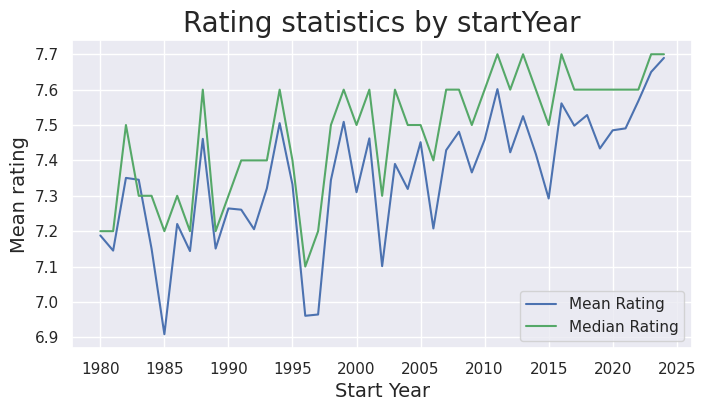

In [ ]:
fig2 = plt.figure(figsize=(8,4))
ax = sns.lineplot(x='startYear',y='average_mean_rating',data=ratings_stats, c='b', label='Mean Rating')
ay = sns.lineplot(x='startYear',y='average_median_rating',data=ratings_stats,c='g', label='Median Rating')
ax.set_xlabel("Start Year",fontsize=14)
ax.set_ylabel("Mean rating",fontsize=14)
plt.title(label='Rating statistics by startYear', fontsize=20)
plt.legend()
fig2.savefig('fig2.png', dpi=fig2.dpi)

С течением времени количество сериалов увеличилось (предыдущий график), затем можно увидеть что в целом рейтинг постепенно становится выше, средний рейтинг становится более стабильным. Падение количества сериалов в связи с ковидом сопровождается ростом рейтинга (то есть отношение зрителей к сериалам в целом не изменилось, люди, сидевшие дома из-за ковида наоборот с большим энтузиазмом воспринимали выходящий контент).

Далее посчитаем для каждого сериала количество сезонов и количество серий.

In [ ]:
seasons_quantity= tv_series_episode_ratings_years.groupby('tconst_x')['seasonNumber'].nunique().reset_index()
episodes_quantity = tv_series_episode_ratings_years.groupby('tconst_x')['episodeNumber'].count().reset_index()
seasons_quantity
quantities= pd.merge(seasons_quantity, episodes_quantity, on='tconst_x')
quantities

,tconst_x,seasonNumber,episodeNumber
0,tt0062614,1,1
1,tt0072584,2,3
2,tt0075509,1,12
3,tt0076980,7,86
4,tt0076995,2,2
...,...,...,...
22543,tt9910672,1,5
22544,tt9910728,2,39
22545,tt9914546,1,2
22546,tt9914700,1,2


Теперь для каждого сериала посчитаем средний рейтинг. Для этого сгруппируем по сериалам, затем посчитаем суммарный рейтинг для каждого эпизода, перемножив оценки и количество голосов, затем суммарный рейтинг для сериала и разделим на количество голосов.

In [ ]:
tv_series_analysis = tv_series_episode_ratings_years[(tv_series_episode_ratings_years['seasonNumber'] != '\\N') &
                                       (tv_series_episode_ratings_years['episodeNumber'] != '\\N') &
                                (tv_series_episode_ratings_years['startYear'] != '\\N')]
tv_series_analysis[['seasonNumber', 'episodeNumber']] = tv_series_analysis[['seasonNumber', 'episodeNumber']].astype(int)
tv_series_analysis.loc[tv_series_analysis.endYear == '\\N', 'endYear'] = ''
tv_series_analysis['sumEpisodeRating'] = tv_series_analysis['averageRating_y'] * tv_series_analysis['numVotes_y']
rating_per_series= tv_series_analysis.groupby('tconst_x')['sumEpisodeRating'].sum()/tv_series_analysis.groupby('tconst_x')['numVotes_y'].sum()
rating_per_series
rating_per_series_df = rating_per_series.reset_index()
rating_per_series_df.columns = ['tconst_x', 'rating_per_series']

In [ ]:
quantities_and_rating=pd.merge(quantities, rating_per_series_df, on='tconst_x')
quantities_and_rating.rename(columns={'seasonNumber': "seasonsQuantity",'episodeNumber': "episodesQuantity"}, inplace=True)
quantities_and_rating

,tconst_x,seasonsQuantity,episodesQuantity,rating_per_series
0,tt0062614,1,1,6.000000
1,tt0072584,2,3,7.303448
2,tt0075509,1,12,6.754359
3,tt0076980,7,86,7.230700
4,tt0076995,2,2,8.400000
...,...,...,...,...
22543,tt9910672,1,5,7.320000
22544,tt9910728,2,39,6.104945
22545,tt9914546,1,2,8.400000
22546,tt9914700,1,2,8.000000


Далее рассмотрим как меняется средний рейтинг сериала в зависимости от количества сезонов и эпизодов (количество эпизодов все же лучше отражает длительность сериала, так как количество эпизодов в каждом сезоне может значительно отличаться.

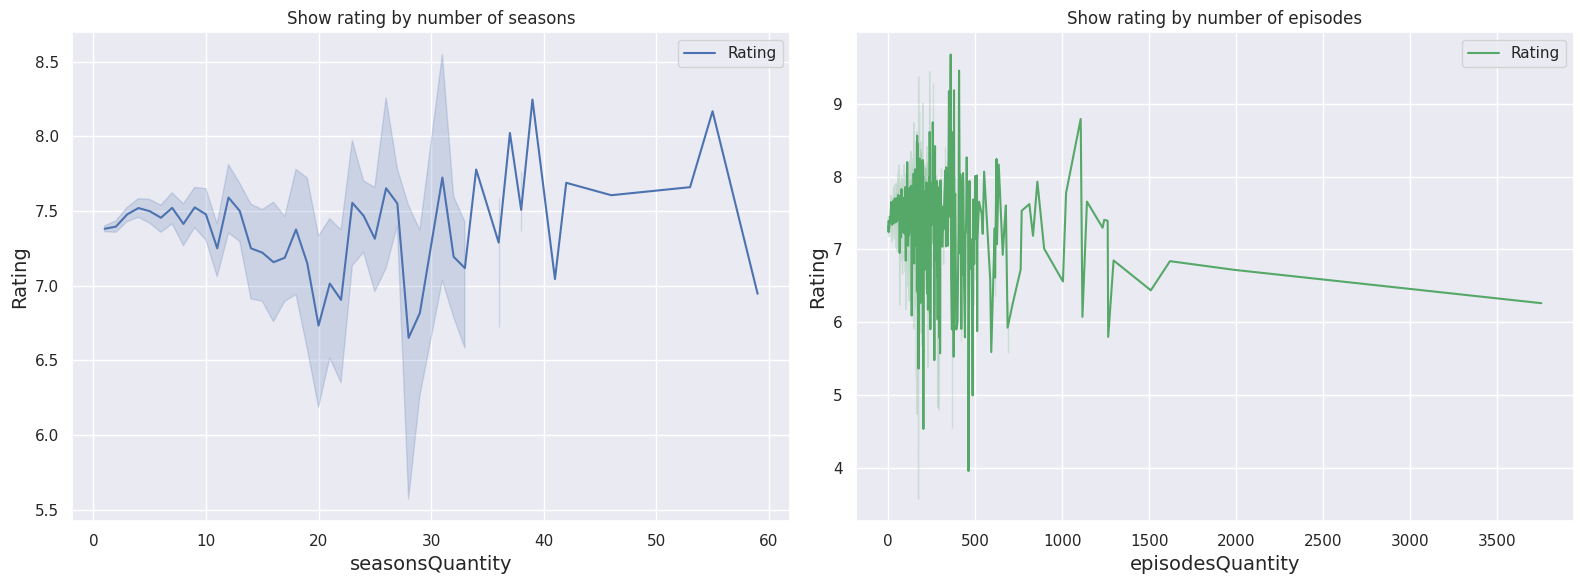

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='seasonsQuantity', y='rating_per_series', data=quantities_and_rating, c='b', ax=ax1, label='Rating')
ax1.set_xlabel("seasonsQuantity", fontsize=14)
ax1.set_ylabel("Rating", fontsize=14)
ax1.set_title("Show rating by number of seasons")
ax1.legend()
sns.lineplot(x='episodesQuantity', y='rating_per_series', data=quantities_and_rating, c='g', ax=ax2, label='Rating')
ax2.set_xlabel("episodesQuantity", fontsize=14)
ax2.set_ylabel("Rating", fontsize=14)
ax2.set_title("Show rating by number of episodes")
ax2.legend()
plt.tight_layout()
plt.show()

В графу TV-Shows входят еженедельные выпуски каких-то регулярных шоу, которые много лет идут по телевизору, на подобие викторин. Чтобы рассмотреть именно сериалы, имеющие сюжет, отсортируем те, у которых меньше 20 сезонов или у которых меньше 400 серий (из расчета 20 серий на сезон).

<ipython-input-23-a60aae363130>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  quantities_and_rating_sorted1=quantities_and_rating_sorted1[quantities_and_rating['episodesQuantity']<=400]


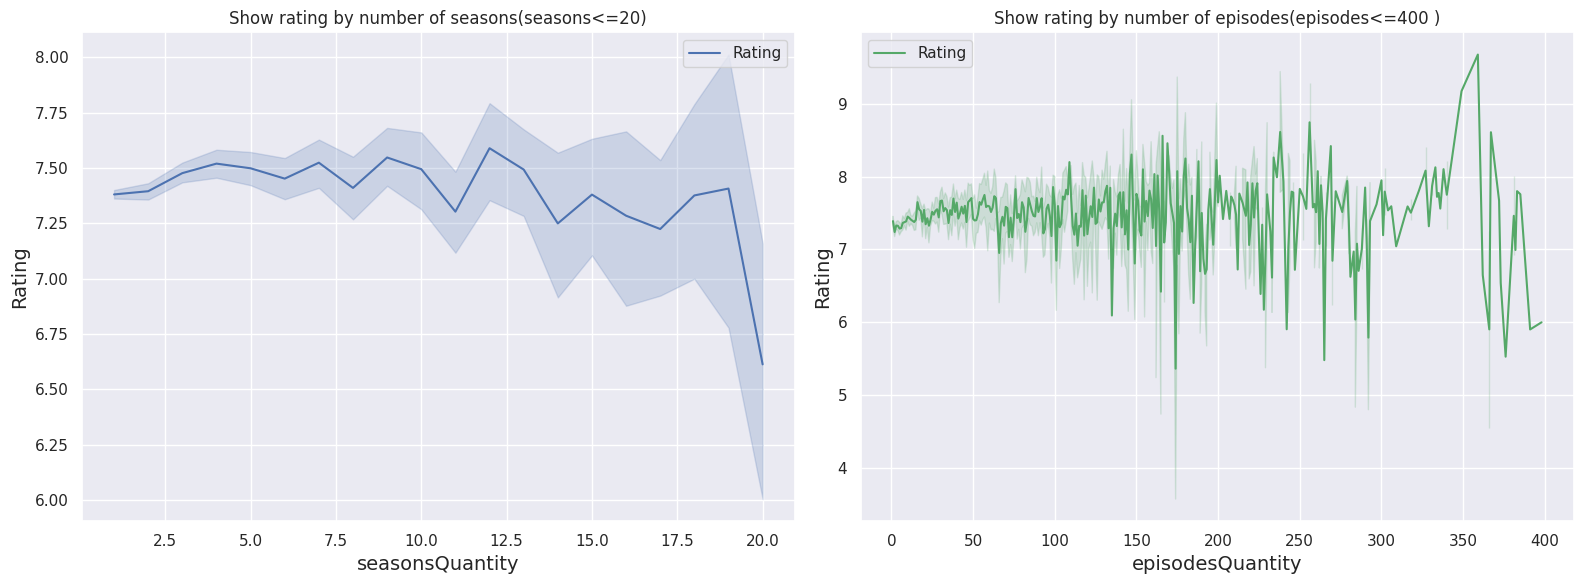

In [ ]:
quantities_and_rating_sorted1=quantities_and_rating[quantities_and_rating['seasonsQuantity']<=20]
quantities_and_rating_sorted1=quantities_and_rating_sorted1[quantities_and_rating['episodesQuantity']<=400]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='seasonsQuantity', y='rating_per_series', data=quantities_and_rating_sorted1, c='b', ax=ax1, label='Rating')
ax1.set_xlabel("seasonsQuantity", fontsize=14)
ax1.set_ylabel("Rating", fontsize=14)
ax1.set_title("Show rating by number of seasons(seasons<=20)")
ax1.legend()
sns.lineplot(x='episodesQuantity', y='rating_per_series', data=quantities_and_rating_sorted1, c='g', ax=ax2, label='Rating')
ax2.set_xlabel("episodesQuantity", fontsize=14)
ax2.set_ylabel("Rating", fontsize=14)
ax2.set_title("Show rating by number of episodes(episodes<=400 )")
ax2.legend()
plt.tight_layout()
plt.show()

Тогда видим тренд на возрастание рейтинга до 9 сезона, затем постепенное падение, которое становится стремительным к 20 сезону. Если смотреть по количеству серий, можно заметить, что разброс в рейтинге становится все более сильным, соответственно чем больше серий (и сезонов), тем больше риск того, что сериал будет хуже оценен зрителями.

Для большей наглядности связи этих параметров добавим граф:

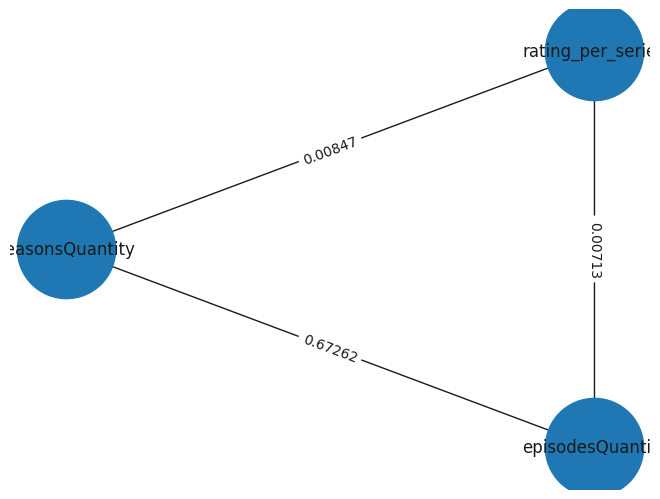

In [ ]:
correlation = quantities_and_rating[['seasonsQuantity', 'episodesQuantity', 'rating_per_series']].corr()
G = nx.Graph()
G.add_node('seasonsQuantity')
G.add_node('episodesQuantity')
G.add_node('rating_per_series')
G.add_edge('seasonsQuantity', 'episodesQuantity', weight=correlation.loc['seasonsQuantity', 'episodesQuantity'].round(5))
G.add_edge('seasonsQuantity', 'rating_per_series', weight=correlation.loc['seasonsQuantity', 'rating_per_series'].round(5))
G.add_edge('episodesQuantity', 'rating_per_series', weight=correlation.loc['episodesQuantity', 'rating_per_series'].round(5))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=5000)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G,pos, edge_labels=edge_labels)
plt.show()

Также стоит рассмотреть влияние продолжительности серии на ее рейтинг.

In [ ]:
tv_series_episode_ratings_years_runtime=tv_series_episode_ratings_years
tv_series_episode_ratings_years_runtime[['runtimeMinutes']] = tv_series_episode_ratings_years_runtime[['runtimeMinutes']].astype(float)
tv_series_episode_ratings_years_runtime=tv_series_episode_ratings_years_runtime[tv_series_episode_ratings_years_runtime['runtimeMinutes']<=60]
tv_series_episode_ratings_years_runtime

<ipython-input-44-877be5435719>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_series_episode_ratings_years_runtime[['runtimeMinutes']] = tv_series_episode_ratings_years_runtime[['runtimeMinutes']].astype(float)


,tconst_x,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating_x,numVotes_x,tconst_y,parentTconst,seasonNumber,episodeNumber,averageRating_y,numVotes_y
37705,tt0062614,tvSeries,Zeg 'ns Aaa,Zeg 'ns Aaa,0.0,1981-01-01,2010.0,23.0,Comedy,6.7,366,tt1075736,tt0062614,8.0,13.0,6.0,6
52012,tt0072584,tvSeries,Wheel of Fortune,Wheel of Fortune,0.0,1983-01-01,NaN,30.0,"Family,Game-Show",6.7,3587,tt1614316,tt0072584,1.0,1.0,8.2,19
52013,tt0072584,tvSeries,Wheel of Fortune,Wheel of Fortune,0.0,1983-01-01,NaN,30.0,"Family,Game-Show",6.7,3587,tt29536371,tt0072584,41.0,26.0,5.4,5
52014,tt0072584,tvSeries,Wheel of Fortune,Wheel of Fortune,0.0,1983-01-01,NaN,30.0,"Family,Game-Show",6.7,3587,tt29845958,tt0072584,41.0,42.0,5.8,5
55696,tt0075509,tvMiniSeries,France/tour/détour/deux/enfants,France/tour/détour/deux/enfants,0.0,1980-01-01,1980.0,26.0,Documentary,7.3,132,tt3817684,tt0075509,1.0,1.0,7.0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720519,tt9916380,tvSeries,Meie aasta Aafrikas,Meie aasta Aafrikas,0.0,2019-01-01,NaN,43.0,"Adventure,Comedy,Family",8.2,119,tt10197828,tt9916380,1.0,6.0,10.0,15
720520,tt9916380,tvSeries,Meie aasta Aafrikas,Meie aasta Aafrikas,0.0,2019-01-01,NaN,43.0,"Adventure,Comedy,Family",8.2,119,tt10197842,tt9916380,1.0,8.0,10.0,15
720521,tt9916380,tvSeries,Meie aasta Aafrikas,Meie aasta Aafrikas,0.0,2019-01-01,NaN,43.0,"Adventure,Comedy,Family",8.2,119,tt10197854,tt9916380,1.0,9.0,9.9,14
720522,tt9916380,tvSeries,Meie aasta Aafrikas,Meie aasta Aafrikas,0.0,2019-01-01,NaN,43.0,"Adventure,Comedy,Family",8.2,119,tt10197874,tt9916380,1.0,10.0,10.0,15


In [ ]:
ratings_by_runtime_mean = tv_series_episode_ratings_years.groupby('runtimeMinutes')['averageRating_y'].mean().reset_index()
ratings_by_runtime_median = tv_series_episode_ratings_years.groupby('runtimeMinutes')['averageRating_y'].median().reset_index()
ratings_stats_runtime=pd.merge(ratings_by_runtime_mean,ratings_by_runtime_median, on='runtimeMinutes')
ratings_stats_runtime.rename(columns={'averageRating_y_x': "average_mean_rating",'averageRating_y_y': "average_median_rating"}, inplace=True)
ratings_stats_runtime

,runtimeMinutes,average_mean_rating,average_median_rating
0,1.0,7.010288,7.20
1,2.0,6.921604,7.00
2,3.0,7.091763,7.10
3,4.0,7.180285,7.20
4,5.0,7.111011,7.10
...,...,...,...
413,1290.0,8.297674,8.40
414,1416.0,8.423077,8.40
415,1440.0,4.950000,4.95
416,1932.0,7.448837,7.60


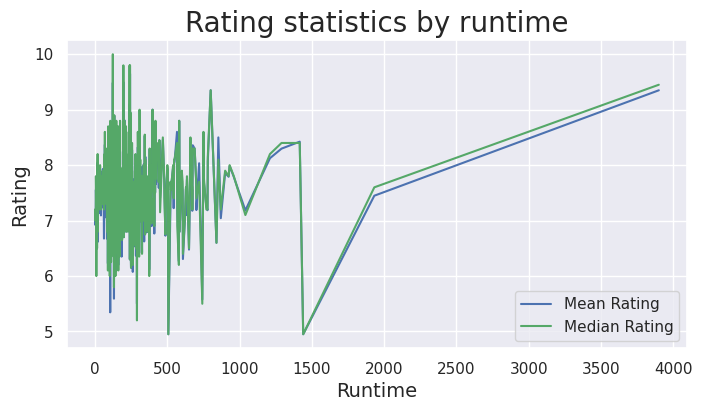

In [ ]:
fig3 = plt.figure(figsize=(8,4))
ax = sns.lineplot(x='runtimeMinutes',y='average_mean_rating',data=ratings_stats_runtime, c='b', label='Mean Rating')
ay = sns.lineplot(x='runtimeMinutes',y='average_median_rating',data=ratings_stats_runtime,c='g', label='Median Rating')
ax.set_xlabel("Runtime",fontsize=14)
ax.set_ylabel("Rating",fontsize=14)
plt.title(label='Rating statistics by runtime', fontsize=20)
plt.legend()
fig3.savefig('fig3.png', dpi=fig3.dpi)